Vision Transformer Code: https://colab.research.google.com/drive/1UD_bybmnndzhi-tvuaqvHNHP5RWIq5zY?usp=sharing

In [ ]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split



In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sovitrath/diabetic-retinopathy-224x224-2019-data")

print("Path to dataset files:", path)

100%|██████████| 238M/238M [00:02<00:00, 95.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sovitrath/diabetic-retinopathy-224x224-2019-data/versions/4


In [ ]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'../root/.cache/kagglehub/datasets/sovitrath/diabetic-retinopathy-224x224-2019-data/versions/4/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


In [ ]:
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

#print number
print(train['type'].value_counts(), '\n')

type
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: count, dtype: int64 



In [ ]:
#create directories for train, val and test. update it everytime the code runs with shutil.rmtree
base_dir = '.\dataset'


train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

#make directories for train, val and test
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
#ensure the directories have the same columns
valid_types = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']
df = df[df['type'].isin(valid_types)]
assert all(train['type'].isin(valid_types))
assert all(val['type'].isin(valid_types))
assert all(test['type'].isin(valid_types))

In [ ]:
#copy the files from the sourcefile to train, validation and test directory respectively
src_dir = r'../root/.cache/kagglehub/datasets/sovitrath/diabetic-retinopathy-224x224-2019-data/versions/4/colored_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    if os.path.exists(srcfile):
      shutil.copy(srcfile, dstfile)
for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, diagnosis)
    os.makedirs(dstfile, exist_ok=True)
    if os.path.exists(srcfile):
        shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, diagnosis)
    os.makedirs(dstfile, exist_ok=True)
    if os.path.exists(srcfile):
        shutil.copy(srcfile, dstfile)





for subdir in [train_dir, val_dir, test_dir]:
    print(f"\nContents of {subdir}:")
    for root, dirs, files in os.walk(subdir):
        print(f"{root}: {len(files)} files")





Contents of .\dataset/train:
.\dataset/train: 0 files
.\dataset/train/Moderate: 699 files
.\dataset/train/Mild: 258 files
.\dataset/train/Severe: 135 files
.\dataset/train/Proliferate_DR: 207 files
.\dataset/train/No_DR: 1263 files

Contents of .\dataset/val:
.\dataset/val: 0 files
.\dataset/val/Moderate: 150 files
.\dataset/val/Mild: 56 files
.\dataset/val/Severe: 29 files
.\dataset/val/Proliferate_DR: 44 files
.\dataset/val/No_DR: 271 files

Contents of .\dataset/test:
.\dataset/test: 0 files
.\dataset/test/Moderate: 150 files
.\dataset/test/Mild: 56 files
.\dataset/test/Severe: 29 files
.\dataset/test/Proliferate_DR: 44 files
.\dataset/test/No_DR: 271 files


In [ ]:
train_path = train_dir
val_path = val_dir
test_path = test_dir

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)


Found 2562 images belonging to 5 classes.
Found 550 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


In [ ]:
#cnn model
model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(5, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(train_batches,
                    epochs=50,
                    validation_data=val_batches)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


81/81 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.4029 - loss: 1.5315 - val_accuracy: 0.5673 - val_loss: 1.5060
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.6735 - loss: 0.9081 - val_accuracy: 0.6727 - val_loss: 1.3945
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.7026 - loss: 0.8166 - val_accuracy: 0.6945 - val_loss: 1.2591
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7062 - loss: 0.8137 - val_accuracy: 0.6855 - val_loss: 1.1358
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.7130 - loss: 0.7965 - val_accuracy: 0.7127 - val_loss: 0.9882
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.7532 - loss: 0.7223 - val_accuracy: 0.7327 - val_loss: 0.8859
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.7584 - loss: 0.7100 - val_accuracy: 0.7382 - val_loss: 0.8226
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.7351 - loss: 0.7226 - val_accuracy: 0.7327 - val_loss: 0.7

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 440ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.8073 - loss: 0.5413 - val_accuracy: 0.7327 - val_loss: 0.7587
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 418ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.8078 - loss: 0.5459 - val_accuracy: 0.7400 - val_loss: 0.7507
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 327ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.8205 - loss: 0.5216 - val_accuracy: 0.7327 - val_loss: 0.7526
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 320ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.8220 - loss: 0.5207 - val_accuracy: 0.7327 - val_loss: 0.7552
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 332ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.8213 - loss: 0.5000 - val_accuracy: 0.7364 - val_loss: 0.7481
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 316ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.8227 - loss: 0.5007 - val_accuracy: 0.7400 - val_loss:

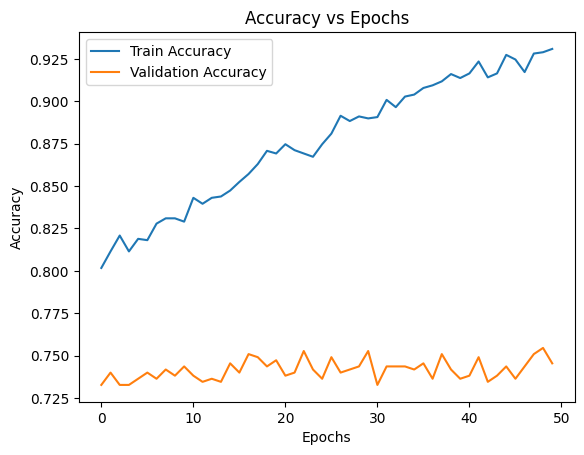

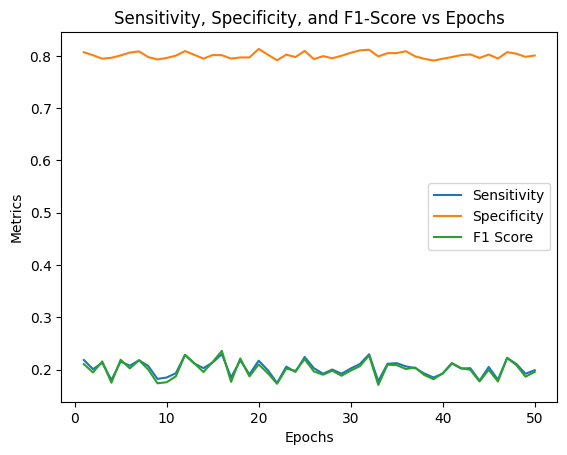

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Custom Callback to compute metrics after each epoch
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_batches):
        self.val_batches = validation_batches
        self.sensitivity = []
        self.specificity = []
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        # Get predictions and ground truths
        y_pred_probs = self.model.predict(self.val_batches)  # Probabilities
        y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted classes
        y_true = self.val_batches.labels  # True labels

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        tp = np.diag(cm)  # True positives for each class
        fp = np.sum(cm, axis=0) - tp  # False positives for each class
        fn = np.sum(cm, axis=1) - tp  # False negatives for each class
        tn = np.sum(cm) - (tp + fp + fn)  # True negatives for each class

        # Avoid division by zero
        recall = tp / (tp + fn + np.finfo(float).eps)  # Sensitivity (Recall)
        specificity = tn / (tn + fp + np.finfo(float).eps)
        precision = tp / (tp + fp + np.finfo(float).eps)
        f1 = 2 * (precision * recall) / (precision + recall + np.finfo(float).eps)

        # Store averages across classes
        self.sensitivity.append(np.mean(recall))
        self.specificity.append(np.mean(specificity))
        self.f1_scores.append(np.mean(f1))

# Initialize callback
metrics_callback = MetricsCallback(validation_batches=val_batches)

# Train the model with the callback
history = model.fit(train_batches,
                    epochs=50,
                    validation_data=val_batches,
                    callbacks=[metrics_callback])

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.savefig('cnn acc vs epoch.png')
plt.show()

# Plot Sensitivity, Specificity, and F1-score
epochs = range(1, len(metrics_callback.sensitivity) + 1)
plt.plot(epochs, metrics_callback.sensitivity, label='Sensitivity')
plt.plot(epochs, metrics_callback.specificity, label='Specificity')
plt.plot(epochs, metrics_callback.f1_scores, label='F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Sensitivity, Specificity, and F1-Score vs Epochs')
plt.legend()
plt.savefig('cnn spec f1 vs epoch.png')
plt.show()


In [ ]:
files.download('cnn acc vs epoch.png')
files.download('cnn spec f1 vs epoch.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.save('64x3-CNN.keras')

In [ ]:
test_loss, test_accuracy = model.evaluate(test_batches)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 329ms/step - accuracy: 0.7009 - loss: 0.8493
Test Accuracy: 73.82%


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 435ms/step


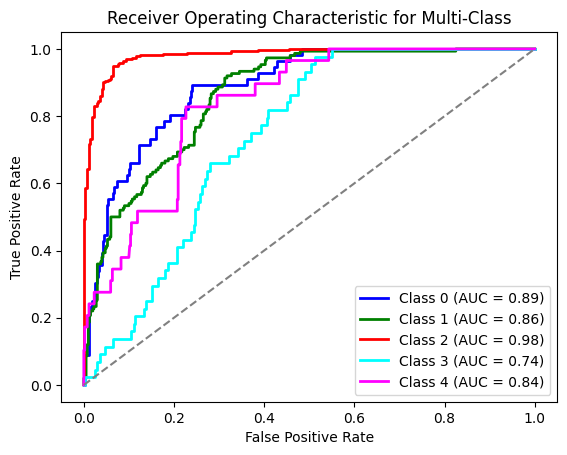

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
y_test = test_batches.labels
# Binarize the output (e.g., for 5 classes)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]  # Number of classes

# Ensure predictions are also in the right shape
y_pred_probs = model.predict(test_batches)  # Probabilities for all classes

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['blue', 'green', 'red', 'cyan', 'magenta']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Add random guess line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc='lower right')
plt.savefig('cnn roc curve.png')
plt.show()



In [ ]:
from google.colab import files
files.download('cnn roc curve.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                precision    recall  f1-score   support

          Mild       0.47      0.50      0.49        56
      Moderate       0.60      0.73      0.66       150
         No_DR       0.89      0.97      0.93       271
Proliferate_DR       0.33      0.02      0.04        44
        Severe       0.60      0.21      0.31        29

      accuracy                           0.74       550
     macro avg       0.58      0.49      0.49       550
  weighted avg       0.71      0.74      0.71       550



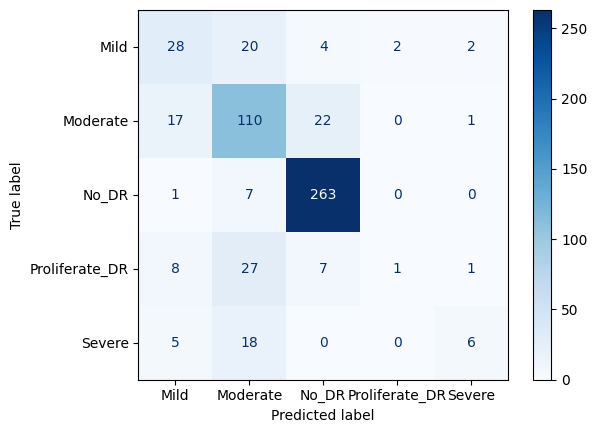

In [ ]:
#generate confusion matrix
from sklearn.metrics import classification_report
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class labels
print(classification_report(y_test, y_pred, target_names=test_batches.class_indices.keys()))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_batches.class_indices.keys())
disp.plot(cmap="Blues")
plt.savefig('cnn confusion matrix.png')
plt.show()



In [ ]:
from google.colab import files
files.download('cnn confusion matrix.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#evaluate training and validation accuracy on a iteratively halving dataset
from math import ceil, pow
src_dir = r'../root/.cache/kagglehub/datasets/sovitrath/diabetic-retinopathy-224x224-2019-data/versions/4/colored_images'
for i in range(5):
  total_files = len(train)
  denom = pow(2, i)
  print(denom)
  files_to_copy = ceil(total_files / denom)  # Half the files, rounded up if odd
  print(files_to_copy)

  if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
  os.makedirs(train_dir, exist_ok=True)


  # Counter to track the number of files copied
  copied_files = 0

  for index, row in train.iterrows():
    if copied_files >= files_to_copy:
        break  # Stop when half of the files are copied

    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok=True)

    if os.path.exists(srcfile):
        shutil.copy(srcfile, dstfile)
        copied_files += 1  # Increment the counter

  for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok=True)
    if os.path.exists(srcfile):
        shutil.copy(srcfile, dstfile)

  for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok=True)
    if os.path.exists(srcfile):
        shutil.copy(srcfile, dstfile)





  for subdir in [train_dir, val_dir, test_dir]:
    print(f"\nContents of {subdir}:")
    for root, dirs, files in os.walk(subdir):
        print(f"{root}: {len(files)} files")

  train_path = train_dir
  val_path = val_dir
  test_path = test_dir

  train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
  val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
  test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

  #cnn model
  model = tf.keras.Sequential([
      layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
      layers.MaxPooling2D(pool_size=(2,2)),
      layers.BatchNormalization(),

      layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
      layers.MaxPooling2D(pool_size=(2,2)),
      layers.BatchNormalization(),

      layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
      layers.MaxPooling2D(pool_size=(2,2)),
      layers.BatchNormalization(),
      layers.Flatten(),
      layers.Dense(32, activation = 'relu'),
      layers.Dropout(0.15),
      layers.Dense(2, activation = 'softmax')
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                loss='categorical_crossentropy',
                metrics=['accuracy'])


  history = model.fit(train_batches,
                      epochs=10,
                      validation_data=val_batches)





1.0
2562

Contents of .\dataset/train:
.\dataset/train: 0 files
.\dataset/train/No_DR: 1263 files
.\dataset/train/DR: 1299 files

Contents of .\dataset/val:
.\dataset/val: 0 files
.\dataset/val/No_DR: 271 files
.\dataset/val/DR: 279 files

Contents of .\dataset/test:
.\dataset/test: 0 files
.\dataset/test/No_DR: 271 files
.\dataset/test/DR: 279 files
Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


81/81 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.7844 - loss: 0.4764 - val_accuracy: 0.5073 - val_loss: 0.8788
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.9100 - loss: 0.2328 - val_accuracy: 0.5073 - val_loss: 1.0356
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9173 - loss: 0.2120 - val_accuracy: 0.5073 - val_loss: 1.1552
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.9285 - loss: 0.1944 - val_accuracy: 0.5109 - val_loss: 0.9722
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9311 - loss: 0.1797 - val_accuracy: 0.5491 - val_loss: 0.6548
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9346 - loss: 0.1593 - val_accuracy: 0.7582 - val_loss: 0.4198
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9482 - loss: 0.1526 - val_accuracy: 0.9164 - val_loss: 0.2454
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9395 - loss: 0.1521 - val_accuracy: 0.9236 - val_loss: 0.1954


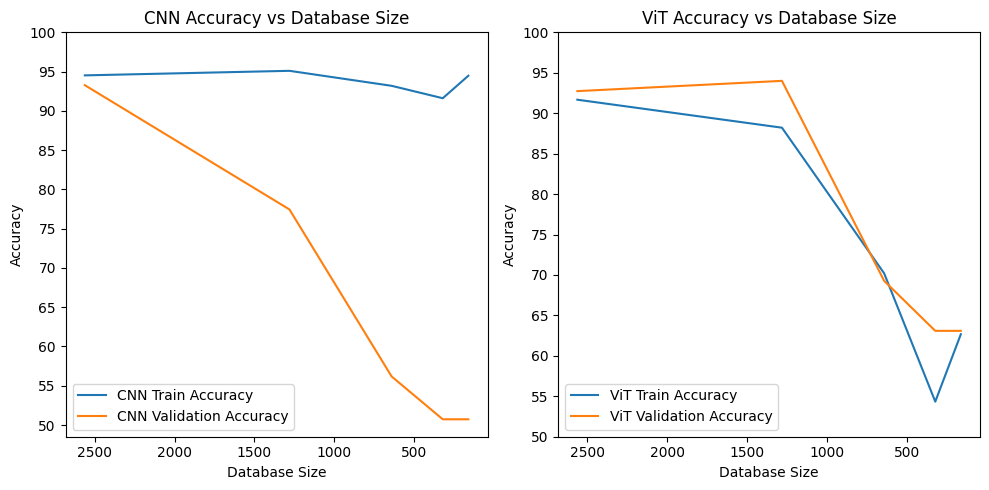

In [ ]:
import matplotlib.pyplot as plt

# Data
database_size = [2562, 1281, 641, 321, 161]
cnn_train_acc = [94.52, 95.10, 93.19, 91.61, 94.47]
cnn_val_acc = [93.27, 77.45, 56.18, 50.73, 50.73]
vit_train_acc = [91.67, 88.21, 70.20, 54.34, 62.67]
vit_val_acc = [92.73, 94, 69.27, 63.09, 63.09]

# Plot
figure, axis = plt.subplots(1, 2, figsize=(10, 5))
# Define the y-ticks with 5 increments
y_ticks = np.arange(50, 101, 5)

# CNN plot
axis[0].plot(database_size, cnn_train_acc, label='CNN Train Accuracy')
axis[0].plot(database_size, cnn_val_acc, label='CNN Validation Accuracy')
axis[0].set_xlabel('Database Size')
axis[0].set_ylabel('Accuracy')
axis[0].set_title('CNN Accuracy vs Database Size')
#axis[0].set_xticks(database_size)  # Set the x-ticks explicitly
axis[0].set_yticks(y_ticks)  # Set consistent y-ticks
axis[0].invert_xaxis()  # Reverse the x-axis
axis[0].legend()

# ViT plot
axis[1].plot(database_size, vit_train_acc, label='ViT Train Accuracy')
axis[1].plot(database_size, vit_val_acc, label='ViT Validation Accuracy')
axis[1].set_xlabel('Database Size')
axis[1].set_ylabel('Accuracy')
axis[1].set_title('ViT Accuracy vs Database Size')
#axis[1].set_xticks(database_size)  # Set the x-ticks explicitly
axis[1].set_yticks(y_ticks)  # Set consistent y-ticks
axis[1].invert_xaxis()  # Reverse the x-axis
axis[1].legend()
plt.savefig('cnn vs vit.png')
plt.tight_layout()
plt.show()



In [ ]:
from google.colab import files
files.download('cnn vs vit.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>